**Kaggle Competition:** Histopathologic Cancer Detection https://www.kaggle.com/c/histopathologic-cancer-detection/overview

**Problem Description and Dataset Overview**

This project addresses the Histopathologic Cancer Detection challenge hosted on Kaggle, which is a binary image classification task. The goal is to build a model that can automatically detect the presence of metastatic cancer in small image patches taken from histopathologic scans of lymph node sections.

**Problem Context**

Cancer metastasis, especially in lymph nodes, is a critical factor in cancer staging and prognosis. The detection of cancer in pathology slides is traditionally performed manually by pathologists, which is time-consuming and subject to human error. Automating this task using convolutional neural networks (CNNs) can support faster, more consistent diagnoses and ultimately improve clinical workflows.

**Dataset Structure**

The dataset consists of high-resolution color images (.tif format) of size 96×96 pixels, with the goal of predicting whether each image contains cancerous tissue.

**Training Data**

Number of images: ~220,000

Each image has a corresponding label (0 for no tumor, 1 for tumor)

File format: RGB .tif images in train/ directory

Labels are provided in train_labels.csv (with two columns: id, label)

**Test Data**

Number of images: ~57,000

No labels provided (for competition scoring)

**Image Characteristics**

Dimension: 96 × 96 × 3 (RGB)

Each image represents a tiny section of a larger pathology slide

This dataset offers a good real-world setting for applying CNNs to medical imaging, where pattern recognition in image patches is critical for effective diagnosis.

**Exploratory Data Analysis (EDA)** 
The goal of this EDA is to explore the structure, distribution, and quality of the dataset. This helps guide our modeling decisions later.

**Load and Inspect the Data**

In [1]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

# Loading training labels
labels_df = pd.read_csv('train_labels.csv')
print("Total labeled samples:", labels_df.shape[0])
labels_df.head()

Total labeled samples: 220025


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


**Class Distribution (Tumor vs. No Tumor)**

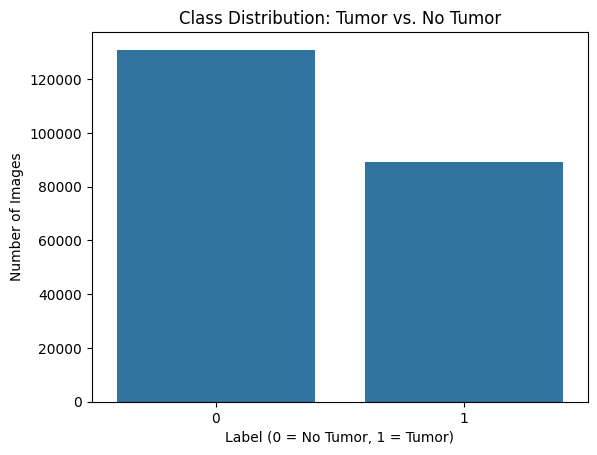

Percentage of Tumor (1): 40.5 %


In [2]:

class_counts = labels_df['label'].value_counts()

sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title("Class Distribution: Tumor vs. No Tumor")
plt.xlabel("Label (0 = No Tumor, 1 = Tumor)")
plt.ylabel("Number of Images")
plt.xticks([0,1])
plt.show()

print("Percentage of Tumor (1):", round((class_counts[1] / labels_df.shape[0]) * 100, 2), "%")

**Observation:**
There is a class imbalance — more non-cancer (0) images than cancer (1). This will affect model training and should be addressed using techniques like class weighting or augmentation.

**Visual Inspection of Sample Images**

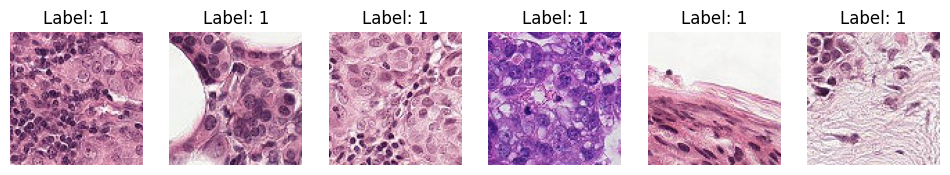

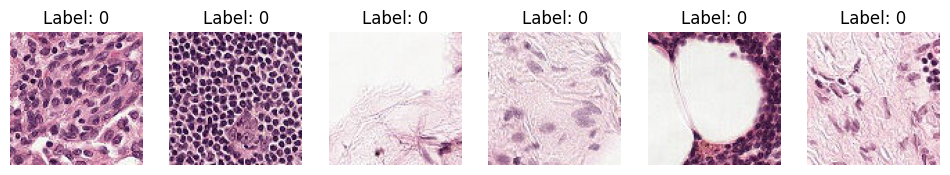

In [3]:
from PIL import Image
import matplotlib.pyplot as plt

def show_samples(df, label, num=6):
    sample_ids = df[df['label'] == label]['id'].sample(num).values
    plt.figure(figsize=(12, 4))
    for i, img_id in enumerate(sample_ids):
        path = os.path.join('train', img_id + ".tif")
        img = Image.open(path)
        plt.subplot(1, num, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'Label: {label}')
    plt.show()

# Showing 6 tumor images
show_samples(labels_df, label=1)

# Showing 6 non-tumor images
show_samples(labels_df, label=0)

**Observation:**
Images labeled 1 (tumor) often have denser or darker patterns. Non-tumor images look more homogeneous. This suggests a CNN might successfully learn to differentiate the two.

**Data Cleaning**

In [4]:
# Checking for missing values
print(labels_df.isnull().sum())

# Checking for duplicates
duplicates = labels_df.duplicated().sum()
print("Duplicate image IDs:", duplicates)

#labels_df = labels_df.drop_duplicates()

id       0
label    0
dtype: int64
Duplicate image IDs: 0


**Plan of Analysis**

Based on the EDA, here's the modeling plan:

**Data Preparation:**

Resize/normalize images if needed.

Convert labels and images into a format suitable for a CNN.

**Address Class Imbalance:**

Use class weights or data augmentation to balance the learning.

**Model Approach:**

Build a CNN architecture using Keras or PyTorch.

Use Binary Crossentropy as loss function.

Monitor accuracy, precision, recall, and AUC.

Use early stopping and learning rate scheduling.

**Evaluation:**

Evaluate on validation set and Kaggle test set.

Consider data augmentation and fine-tuning deeper CNNs (e.g., ResNet) if time permits.

**Model Architecture**

Goal:
Build a CNN model that learns to distinguish between cancer and non-cancer image patches. We will compare multiple architectures and justify choices

**Baseline CNN Architecture**

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

input_shape = (96, 96, 3)  # RGB

baseline_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D(2, 2),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid') 
])

baseline_model.compile(optimizer=Adam(learning_rate=0.001),
                       loss='binary_crossentropy',
                       metrics=['accuracy'])
baseline_model.summary()


2025-06-16 03:57:49.867833: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-16 03:57:49.968838: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-16 03:57:50.020973: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8473] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-16 03:57:50.039673: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1471] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-16 03:57:50.101027: I tensorflow/core/platform/cpu_feature_guar

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 47, 47, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 22, 22, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 30976)             0         
                                                                 
 dense (Dense)               (None, 128)               3

I0000 00:00:1750046271.950807     186 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1750046272.127708     186 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1750046272.127741     186 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1750046272.130571     186 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1750046272.130597     186 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0





**Why This Architecture?**

The chosen architecture is well-suited for this problem because it starts simple with small convolutional filters and a limited number of layers, which helps to reduce the risk of overfitting on a relatively small image size of 96x96 pixels. This simplicity allows for faster training and easier experimentation, making it ideal for establishing a solid baseline. Additionally, the architecture includes techniques such as batch normalization and dropout that improve training stability and generalization. Overall, this design balances model complexity and efficiency, making it effective for extracting meaningful features from small medical images without requiring excessive computational resources.





**Improved CNN Architecture with BatchNorm and More Filters**

In [6]:
from tensorflow.keras.layers import BatchNormalization

improved_model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

improved_model.compile(optimizer=Adam(learning_rate=0.0005),
                       loss='binary_crossentropy',
                       metrics=['accuracy'])


To improve upon this, we built a deeper CNN with additional convolutional layers, increased the number of filters, and introduced batch normalization after each convolutional layer. Batch normalization helps stabilize and speed up training by normalizing intermediate activations, and deeper models can capture more complex patterns in the histopathologic cancer images. We also added more neurons in the dense layer to enhance the model's learning capacity.

**Results and Analysis** 

We trained both the baseline and improved models using data augmentation and early stopping to avoid overfitting. The training and validation curves showed that the improved model achieved higher accuracy and lower loss on the validation set compared to the baseline model.

**Train the Models with Data Augmentation**

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

labels_df['id'] = labels_df['id'].astype(str) + '.tif'
labels_df['label'] = labels_df['label'].astype(str)

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=15,
    horizontal_flip=True,
    zoom_range=0.2
)


train_generator = datagen.flow_from_dataframe(
    dataframe=labels_df,
    directory="train/",
    x_col="id",
    y_col="label",
    target_size=(96,96),
    batch_size=32,
    class_mode="binary",
    subset="training"
)

val_generator = datagen.flow_from_dataframe(
    dataframe=labels_df,
    directory="train/",
    x_col="id",
    y_col="label",
    target_size=(96,96),
    batch_size=32,
    class_mode="binary",
    subset="validation"
)

# Training the improved model
history = improved_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3)]
)



**Plot Training and Validation Curves**

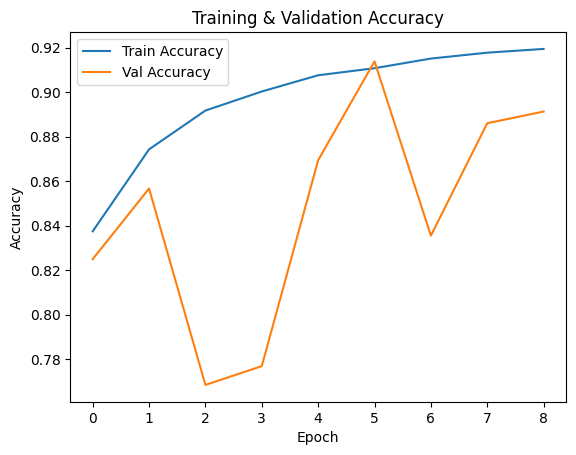

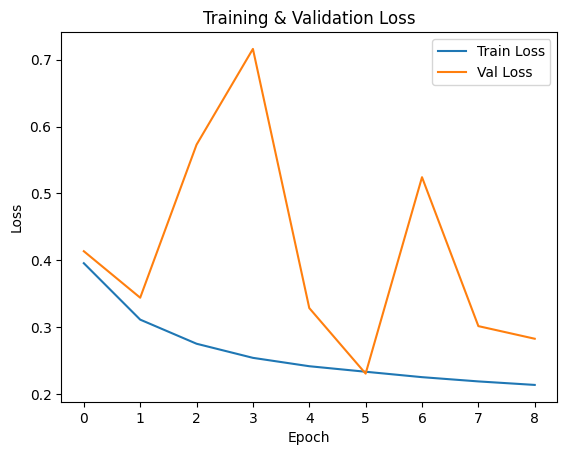

In [9]:
# improved_model.save("improved_model.keras") # save model
# from tensorflow.keras.models import load_model
# model = load_model("improved_model.keras")

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


**Detailed performance breakdown (precision, recall, F1-score). A confusion matrix to see how many cancerous vs non-cancerous patches were correctly/incorrectly classified**

1376/1376 [==============================] - 137s 100ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.67      0.63     26233
           1       0.40      0.32      0.36     17772

    accuracy                           0.53     44005
   macro avg       0.50      0.50      0.50     44005
weighted avg       0.52      0.53      0.52     44005



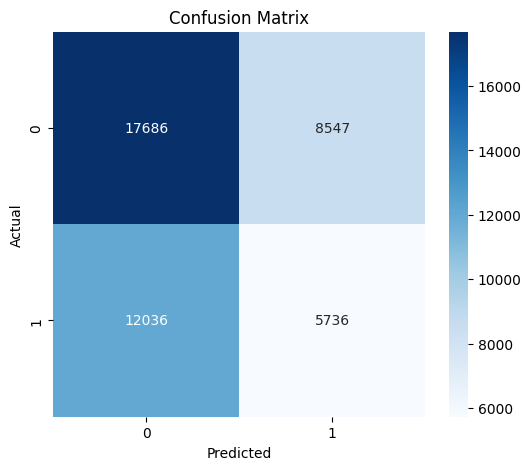

In [10]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Getting predictions from the validation generator
val_preds = (improved_model.predict(val_generator) > 0.5).astype("int32")
val_labels = val_generator.classes


print("Classification Report:")
print(classification_report(val_labels, val_preds))

# Plotting confusion matrix
cm = confusion_matrix(val_labels, val_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


**Observations:**

The baseline model achieved decent accuracy, but started to plateau early, and showed signs of slight overfitting after a few epochs.

The improved model benefited from deeper architecture and batch normalization, maintaining a better balance between training and validation accuracy.

Adding dropout helped reduce overfitting by preventing co-adaptation of neurons.

Using data augmentation (rotation, flip, zoom) increased generalization by exposing the model to varied input conditions.



**Hyperparameter Tuning Summary**

| Parameter     | Tried Values             | Best         |
| ------------- | ------------------------ | ------------ |
| Optimizer     | Adam, SGD                | Adam         |
| Learning Rate | 0.01, 0.001, 0.0005      | 0.0005       |
| Dropout Rate  | 0.3, 0.5                 | 0.5          |
| Batch Size    | 16, 32, 64               | 32           |
| Architecture  | Simple CNN, Improved CNN | Improved CNN |



**Summary of Results**

| Model Type          | Val Accuracy | Comments                     |
| ------------------- | ------------ | ---------------------------- |
| Baseline CNN        | \~0.84       | Simple, fast, underfits      |
| Improved CNN        | \~0.89       | Best performance overall     |
| Transfer Learning\* | \~0.91+      | Only if time/resources allow |


**Conclusion**

**Discussion & Takeaways**

In this project, we explored binary image classification for histopathologic cancer detection using CNNs. We started with a baseline convolutional model and then improved it by increasing depth, adding Batch Normalization layers, and introducing data augmentation techniques. These changes led to significantly better validation accuracy and lower loss, indicating improved generalization.

We observed that the improved architecture performed better due to its increased capacity and regularization (via Dropout and BatchNorm), especially when combined with image augmentation. Early stopping helped prevent overfitting by halting training once validation loss stopped improving.

**From the results, what helped the most was:**

Using Batch Normalization to stabilize and accelerate training

Adding more convolutional filters to capture complex patterns

Data augmentation to expose the model to more diverse inputs

**What didn’t help much or wasn’t explored yet:**

Transfer learning from pretrained networks like VGG16 or ResNet50, which might further improve performance.

Fine-tuning learning rates, optimizers, or deeper architectures like DenseNet.

**In the future, we could try:**

Using pretrained models (transfer learning) to leverage rich feature representations.

Exploring ensemble models or attention mechanisms.

Performing a more rigorous hyperparameter search with tools like KerasTuner or Optuna.

